In [ ]:
# default_exp doublediff_analysis

In [ ]:
#export
def calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2):#check for speedup
    fcfc_res = 0
    count_fcfcs = 0
    z_summed = 0
    for idx1 in overlapping_c1_idx:
        for idx2 in overlapping_c2_idx:
            fc_ion1 = ion1_c1_ints[idx1] - ion1_c2_ints[idx2]
            fc_ion2 = ion2_c1_ints[idx1] - ion2_c2_ints[idx2]
            fcfc_idxpair = fc_ion1 - fc_ion2
            z_idxpair = get_z_for_idxpair(ddeed_ion1_ion2, fcfc_idxpair)
            fcfc_res += fcfc_idxpair
            z_summed += z_idxpair
            count_fcfcs+=1
    if count_fcfcs==0:
        raise Exception("no idx overlap even though filtering has happened!")

    return z_summed, fcfc_res/count_fcfcs

def get_z_for_idxpair(ddeed_ion1_ion2, fcfc_idxpair):
    return ddeed_ion1_ion2.calc_zscore_from_fc(fcfc_idxpair)







def calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffdist, p2z):
    
    secondterm_variance = 0
    
    for ionpair in all_ionpairs:
        for ion in ionpair:
            compare_pairs = ion2pairs.get(ion)
            compare_pairs.remove(ionpair)
            
            for comp_ionpair in compare_pairs:

                comp_ion = comp_ionpair[0]

                idxs_ionpair = ionpair2idx_ols.get(ionpair)
                idxs_comp_ionpair = ionpair2idx_ols.get(comp_ionpair)
                
                n_sameidx_first = len(set(idxs_ionpair[0]).intersection(set(idxs_comp_ionpair[0])))
                n_sameidx_second = len(set(idxs_ionpair[1]).intersection(set(idxs_comp_ionpair[1])))

                deed1 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, ion, p2z)
                deed2 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, comp_ion, p2z)

                eed_ion_c1 = normed_c1.ion2background.get(ion)
                eed_ion_c2 = normed_c2.ion2background.get(ion)

                correlation_normfact = deed1.SD * deed2.SD
                
                var_overlap = len(idxs_ionpair[1])*len(idxs_comp_ionpair[1]) * n_sameidx_first * eed_ion_c1.var + len(idxs_ionpair[0])*len(idxs_comp_ionpair[0]) * n_sameidx_second * eed_ion_c2.var
                secondterm_variance += var_overlap/correlation_normfact
                
    return secondterm_variance


from statistics import NormalDist

def calculate_scaled_pval(z_sum, firstterm_variance, secondterm_variance):
    scaled_SD = np.sqrt((firstterm_variance+secondterm_variance))
    p_val = 2.0 * (1.0 -  NormalDist(mu=0, sigma= scaled_SD).cdf(abs(z_sum)))
    return p_val



In [ ]:
#export
import alphaquant.background_distributions as aqbg
import numpy as np


def calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist):
    """Gives a p-value for the null hypothesis: No change between the foldchanges of the ions1 in comparison to the ions2

    Args:
        ions1 (list[String]): list of ions1 to compared to ions1
        ions2 (list[String]): list of ions2  to be compared to ions1
        normed_c1 (ConditionBackground): Condition background ions1
        normed_c2 (ConditionBackground): Condition background ions2
        ion2diffDist (dict[String : EmpiricalBackground]): map from each ion to its assigned empirical background distribution
        p2z (dict[double:double]): map from p-value to z-value (lookup to improve runtime)
        deedpair2doublediffdist (dict[(EmpiricalBackground, EmpiricalBackground) : EmpiricalBackground]): map from each pair of empirical backgrounds to the subtracted empirical background representing the double differential noise

    Returns:
        double: p-value as specified above
    """
    z_total = 0
    fcfc_total = 0
    count_pairs = 0
    firstterm_variance = 0
    all_ionpairs = []
    ion2pairs = {}
    ionpair2idx_ols = {}

    nrep_c1 = len(normed_c1.ion2allvals.get(ions1[0]))
    nrep_c2 = len(normed_c2.ion2allvals.get(ions2[0]))
    
    for ion1 in ions1:
        ion1_c1_ints = normed_c1.ion2allvals.get(ion1)
        ion1_c2_ints = normed_c2.ion2allvals.get(ion1)
        for ion2 in ions2:
            ion2_c1_ints = normed_c1.ion2allvals.get(ion2)
            ion2_c2_ints = normed_c2.ion2allvals.get(ion2)

            #account for missing values: ion1 and ion2 values are only compared within the same sample -> filter for intensities that occur in the same sample for both ions
            overlapping_c1_idx = [x for x in range(nrep_c1) if (~np.isnan(ion1_c1_ints[x])) & (~np.isnan(ion2_c1_ints[x]))]
            nrep_ol_c1 = len(overlapping_c1_idx)
            if nrep_ol_c1 ==0:
                continue

            overlapping_c2_idx = [x for x in range(nrep_c2) if (~np.isnan(ion1_c2_ints[x])) & (~np.isnan(ion2_c2_ints[x]))]
            nrep_ol_c2 = len(overlapping_c2_idx)
            if nrep_ol_c2 ==0:
                continue

            #collection information for later variance calculation
            ionpair = (ion1, ion2)
            all_ionpairs.append(ionpair)
            ion2pairs[ion1] = ion2pairs.get(ion1, []) + [ionpair]
            ion2pairs[ion2] = ion2pairs.get(ion2, []) + [ionpair]
            ionpair2idx_ols[ionpair] = [overlapping_c1_idx, overlapping_c2_idx]

            #define all empirical error distributions (eed) and differential empirical error distributions (deed) and obtain the variance 
            eed_ion1_c1 = normed_c1.ion2background.get(ion1)
            eed_ion1_c2 = normed_c2.ion2background.get(ion1)

            eed_ion2_c1 = normed_c1.ion2background.get(ion2)
            eed_ion2_c2 = normed_c2.ion2background.get(ion2)

            deed_ion1 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion1, p2z)
            deed_ion2 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion2, p2z)

            #calculate the ionpair total variance as shown in Berchtold et al. EmpiReS

            ionpair_variance = (nrep_ol_c1 * nrep_ol_c2 *(deed_ion1.var + deed_ion2.var) + nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c2-1) * (eed_ion1_c1.var + eed_ion2_c1.var) +
             nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c1-1) * (eed_ion1_c2.var + eed_ion2_c2.var))/(deed_ion1.var + deed_ion2.var)

            firstterm_variance += ionpair_variance

            #calculate z-value and fcfc for the ion pair
            ddeed_ion1_ion2 = aqbg.get_doublediff_bg(deed_ion1, deed_ion2, deedpair2doublediffdist,p2z)
            z_pair, fcfc_pair = calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2)
            z_total+=z_pair
            fcfc_total+=fcfc_pair
            count_pairs+=1
    
    if count_pairs==0: # in this case, it was not possible to find any sample overlaps -> no comparison "possible"
        return 0, 1e-16 # classify as "dissimilar" in this case
    secondterm_variance = calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffDist, p2z)
    fcfc = fcfc_total/count_pairs
    pval = calculate_scaled_pval(z_total, firstterm_variance, secondterm_variance)

    return fcfc, pval

## Unit Tests

In [ ]:
#hide
import uuid
import alphaquant.background_distributions as aqbg
import alphaquant.benchmarking as aqbm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def test_doublediff(num_ionsets = 10, fixed_size = None, simulate_nas = True):

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(100000, sample2cond_df,simulate_nas)
    display(unnormed_df)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    pvals = test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size)
    return pvals


def test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size = None):
    pvals = []
    fcfcs = []
    allions = list(set(normed_c1.ion2background.keys()).intersection(set(normed_c2.ion2background.keys())))
    allions = np.array(allions)
    if fixed_size is not None:
        ionsets = [allions[np.random.randint(len(allions), size=fixed_size)] for _ in range(num_ionsets)]
    else:
        ionsets = [allions[np.random.randint(len(allions), size=np.random.randint(1,10))] for _ in range(num_ionsets)]

    count_iters = 0
    ion2diffDist={} 
    p2z ={} 
    deedpair2doublediffdist = {}

    for ions1, ions2 in itertools.combinations(ionsets, 2):
        print(f"ionpair {len(ions1)} {len(ions2)}\n{count_iters} of {len(ionsets)*(len(ionsets)-1)/2}")
        count_iters+=1
        fcfc, p = calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist)
        pvals.append(p)
        fcfcs.append(fcfc)
    
    return pvals, fcfcs
    

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2


pvals_differentsizes,_ = test_doublediff(50)
pvals_fixedsize, fcfcs_fixedsize = test_doublediff(50, fixed_size = 4, simulate_nas=False)



47193


,A1,protein,A2,A3,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
ion,,,,,,,,,,,,,,,,
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,NaN,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1,NaN,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,NaN,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod1,8.683319,P0,11.519809,11.283816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep0_LVL0_mod0_LVL1_mod1_LVL2_mod0_LVL3_mod0,8.730013,P0,10.341221,9.154842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pep8481_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,10.721045,P7836,10.141889,9.521187,10.317578,12.808167,9.531749,13.439560,7.907221,15.700445,10.319165,9.951346,9.230624,4.798879,11.723903,11.534368
pep8481_LVL0_mod0_LVL1_mod0_LVL2_mod2_LVL3_mod0,10.434221,P7836,6.511333,9.100536,10.014399,2.517431,9.097708,12.269468,11.932853,10.860084,8.340925,7.864954,12.665925,7.989928,5.912909,10.196860
pep8481_LVL0_mod0_LVL1_mod0_LVL2_mod3_LVL3_mod0,9.205706,P7836,11.062630,10.267256,15.129613,-0.444607,13.410378,8.553251,9.180397,14.419779,15.305989,4.033089,6.616482,11.292360,14.945294,14.250801


t_ion2nonan_sw 0.11651396751403809
t_intensity_selection 2.8691349029541016
t_ion2nonan_sw 0.09642314910888672
t_intensity_selection 7.823667049407959
ionpair 6 5
0 of 1225.0
ionpair 6 5
1 of 1225.0
ionpair 6 9
2 of 1225.0
ionpair 6 3
3 of 1225.0
ionpair 6 1
4 of 1225.0
ionpair 6 6
5 of 1225.0
ionpair 6 2
6 of 1225.0
ionpair 6 3
7 of 1225.0
ionpair 6 2
8 of 1225.0
ionpair 6 3
9 of 1225.0
ionpair 6 5
10 of 1225.0
ionpair 6 4
11 of 1225.0
ionpair 6 9
12 of 1225.0
ionpair 6 3
13 of 1225.0
ionpair 6 8
14 of 1225.0
ionpair 6 7
15 of 1225.0
ionpair 6 8
16 of 1225.0
ionpair 6 6
17 of 1225.0
ionpair 6 6
18 of 1225.0
ionpair 6 6
19 of 1225.0
ionpair 6 2
20 of 1225.0
ionpair 6 5
21 of 1225.0
ionpair 6 6
22 of 1225.0
ionpair 6 2
23 of 1225.0
ionpair 6 2
24 of 1225.0
ionpair 6 9
25 of 1225.0
ionpair 6 5
26 of 1225.0
ionpair 6 4
27 of 1225.0
ionpair 6 8
28 of 1225.0
ionpair 6 9
29 of 1225.0
ionpair 6 2
30 of 1225.0
ionpair 6 8
31 of 1225.0
ionpair 6 8
32 of 1225.0
ionpair 6 9
33 of 1225.0
ionpair 6

,A1,protein,A2,A3,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
ion,,,,,,,,,,,,,,,,
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,10.184119,P0,10.508434,6.753406,7.924712,5.826217,11.362282,9.913828,9.348390,5.488085,8.544248,8.230925,9.680618,5.858197,12.592045,9.896888
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1,11.559379,P0,10.375352,8.531888,3.339904,10.648172,12.637209,6.203150,8.273816,10.295796,10.500442,12.833427,11.822323,14.630506,7.865900,9.474578
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,10.184633,P0,11.721090,6.642639,10.164505,9.067370,5.467870,9.626165,5.350362,8.345820,9.748703,4.459878,11.417684,14.581194,14.310095,10.015260
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod1,9.190885,P0,10.831713,9.598162,6.705726,6.257138,7.637612,9.775682,7.775109,9.301266,5.653455,7.388539,6.454758,8.097543,15.920045,10.771951
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod2_LVL3_mod0,6.063331,P0,10.200550,11.263318,12.360533,13.117207,11.137922,6.273892,2.998141,11.343651,9.252908,6.610697,11.462544,16.678891,6.182626,3.148895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pep8374_LVL0_mod0_LVL1_mod1_LVL2_mod1_LVL3_mod1,7.991902,P7913,9.189885,9.490185,10.513246,9.727761,5.829276,5.405124,9.224488,13.865530,6.032938,11.033535,11.892034,15.994610,7.591258,2.107730
pep8374_LVL0_mod0_LVL1_mod1_LVL2_mod2_LVL3_mod0,12.044934,P7913,10.856619,11.098264,5.527326,8.308035,13.289275,14.999370,3.134240,13.113045,2.855655,12.899310,8.690204,5.104251,11.172052,14.176399
pep8374_LVL0_mod0_LVL1_mod1_LVL2_mod2_LVL3_mod1,10.220973,P7913,15.321239,10.292707,9.590298,18.111812,17.074122,13.350570,3.323191,14.202956,15.900731,12.668914,2.424836,5.484896,11.734955,9.388440


t_ion2nonan_sw 0.11195778846740723
t_intensity_selection 2.4893829822540283
t_ion2nonan_sw 0.09618782997131348
t_intensity_selection 8.210057020187378
ionpair 4 4
0 of 1225.0
ionpair 4 4
1 of 1225.0
ionpair 4 4
2 of 1225.0
ionpair 4 4
3 of 1225.0
ionpair 4 4
4 of 1225.0
ionpair 4 4
5 of 1225.0
ionpair 4 4
6 of 1225.0
ionpair 4 4
7 of 1225.0
ionpair 4 4
8 of 1225.0
ionpair 4 4
9 of 1225.0
ionpair 4 4
10 of 1225.0
ionpair 4 4
11 of 1225.0
ionpair 4 4
12 of 1225.0
ionpair 4 4
13 of 1225.0
ionpair 4 4
14 of 1225.0
ionpair 4 4
15 of 1225.0
ionpair 4 4
16 of 1225.0
ionpair 4 4
17 of 1225.0
ionpair 4 4
18 of 1225.0
ionpair 4 4
19 of 1225.0
ionpair 4 4
20 of 1225.0
ionpair 4 4
21 of 1225.0
ionpair 4 4
22 of 1225.0
ionpair 4 4
23 of 1225.0
ionpair 4 4
24 of 1225.0
ionpair 4 4
25 of 1225.0
ionpair 4 4
26 of 1225.0
ionpair 4 4
27 of 1225.0
ionpair 4 4
28 of 1225.0
ionpair 4 4
29 of 1225.0
ionpair 4 4
30 of 1225.0
ionpair 4 4
31 of 1225.0
ionpair 4 4
32 of 1225.0
ionpair 4 4
33 of 1225.0
ionpair 4

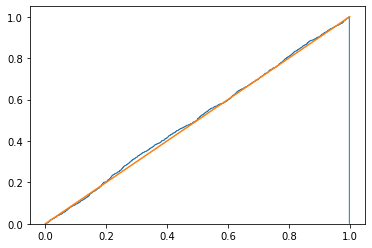

0.11645364827407823


<AxesSubplot:>

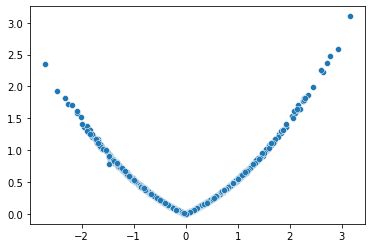

In [ ]:
#hide
import alphaquant.visualizations as aqviz
import scipy.stats as stats
import seaborn as sns

plt.hist(pvals_differentsizes, cumulative=True, bins = 1000, histtype = "step", density = True)
x = np.linspace(0,1,100)
plt.plot(x, x)
plt.show()
unidist = np.random.uniform(size=1000)

pval = stats.ks_2samp(pvals_fixedsize, unidist)[1]
assert(pval>0.01)

sns.scatterplot(x = fcfcs_fixedsize,y = -np.log10(pvals_fixedsize))

